In [2]:
import torch
import torchkbnufft as tkbn
import numpy as np
print(torch.cuda.is_available())
if (torch.cuda.is_available()):
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
import mapvbvd
import scipy.io as io
import matplotlib.pyplot as plt
from mrisensesim import mrisensesim

True


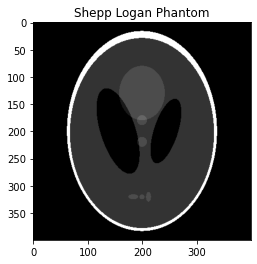

In [5]:
from skimage.data import shepp_logan_phantom
image = shepp_logan_phantom().astype(complex)
im_size = image.shape
plt.imshow(np.abs(image))
plt.gray()
plt.title('Shepp Logan Phantom')
plt.show()

In [6]:
image = torch.tensor(image, dtype=torch.complex64).unsqueeze(0).unsqueeze(0)
print('image shpae = ', image.shape)

image shpae =  torch.Size([1, 1, 400, 400])


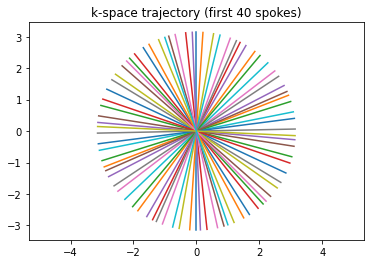

In [20]:
spokelength = image.shape[-1]*2
grid_size = (spokelength, spokelength)
nspokes = 405

ga = np.deg2rad(180 / ((1+np.sqrt(5)) / 2))
kx = np.zeros(shape=(spokelength, nspokes))
ky = np.zeros(shape=(spokelength, nspokes))
ky[:,0] = np.linspace(-np.pi, np.pi, spokelength)
for i in range(1, nspokes):
    kx[:, i] = np.cos(ga) * kx[:, i-1] - np.sin(ga) * ky[:, i-1]
    ky[:, i] = np.sin(ga) * kx[:, i-1] + np.cos(ga) * ky[:, i-1]
ky = np.transpose(ky)
kx = np.transpose(kx)

ktraj = np.stack((ky.flatten(), kx.flatten()), axis = 0)

plt.plot(kx[:40, :].transpose(), ky[:40, :].transpose())
plt.axis('equal')
plt.title('k-space trajectory (first 40 spokes)')
plt.show()

In [21]:
ktraj = torch.tensor(ktraj, dtype=torch.float)
print('ktraj shape ', ktraj.shape)

ktraj shape  torch.Size([2, 324000])


/tmp/ipykernel_104006/2474226724.py:2: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  smap = np.abs(np.stack(mrisensesim(im_size, coil_width=64))).astype(np.complex)


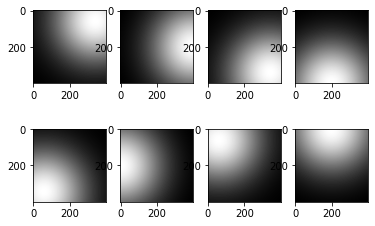

In [11]:
ncoil = 8
smap = np.abs(np.stack(mrisensesim(im_size, coil_width=64))).astype(np.complex)

fig, axs = plt.subplots(2, 4)
for i, ax in enumerate(axs.flat):
    ax.imshow(np.abs(smap[i]))
plt.gray()
plt.show()

In [12]:
smap = torch.tensor(smap, dtype=torch.complex64).unsqueeze(0)

In [13]:
nufft_ob = tkbn.KbNufft(im_size=im_size, grid_size=grid_size).to(device)
adjnufft_ob = tkbn.KbNufftAdjoint(im_size=im_size, grid_size=grid_size).to(device)

print(nufft_ob)
print(adjnufft_ob)


KbNufft
----------------------------------------
buffers
	tensor: table_0, shape: (6145,)
	tensor: table_1, shape: (6145,)
	tensor: im_size, shape: (2,)
	tensor: grid_size, shape: (2,)
	tensor: n_shift, shape: (2,)
	tensor: numpoints, shape: (2,)
	tensor: offsets, shape: (36, 2)
	tensor: table_oversamp, shape: (2,)
	tensor: order, shape: (2,)
	tensor: alpha, shape: (2,)
	tensor: scaling_coef, shape: (400, 400)


KbNufftAdjoint
----------------------------------------
buffers
	tensor: table_0, shape: (6145,)
	tensor: table_1, shape: (6145,)
	tensor: im_size, shape: (2,)
	tensor: grid_size, shape: (2,)
	tensor: n_shift, shape: (2,)
	tensor: numpoints, shape: (2,)
	tensor: offsets, shape: (36, 2)
	tensor: table_oversamp, shape: (2,)
	tensor: order, shape: (2,)
	tensor: alpha, shape: (2,)
	tensor: scaling_coef, shape: (400, 400)



In [22]:
image = image.to(device)
ktraj = ktraj.to(device)
smap = smap.to(device)
kdata = nufft_ob(image, ktraj, smaps=smap)

In [23]:
dcomp = tkbn.calc_density_compensation_function(ktraj=ktraj, im_size=im_size)
image_sharp = adjnufft_ob(kdata * dcomp, ktraj, smaps=smap)

/home/fs0/qijia/miniconda3/envs/pytorch-1.1-gpu_py39/lib/python3.9/site-packages/torchkbnufft/_nufft/interp.py:651: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  if num_threads // factor <= data.shape[0] * data.shape[1]:


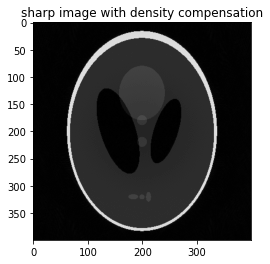

In [24]:
image_sharp_numpy = np.squeeze(image_sharp.cpu().numpy())

plt.figure()
plt.imshow(np.abs(image_sharp_numpy))
plt.gray()
plt.title('sharp image with density compensation')
plt.show()